# Check pipeline

In [1]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
	"runwayml/stable-diffusion-v1-5", 
	use_auth_token=True
).to("cuda")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

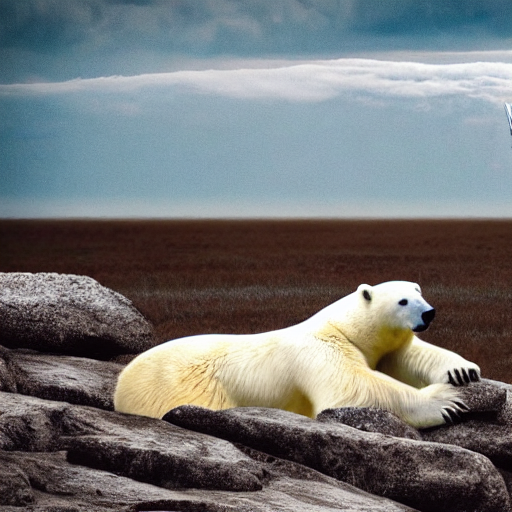

In [2]:
pipe("a polar bear laying on top of a pile of rocks and a fighter jet flying through a cloudy sky").images[0] # type: ignore

# Effective and efficient diffusion

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

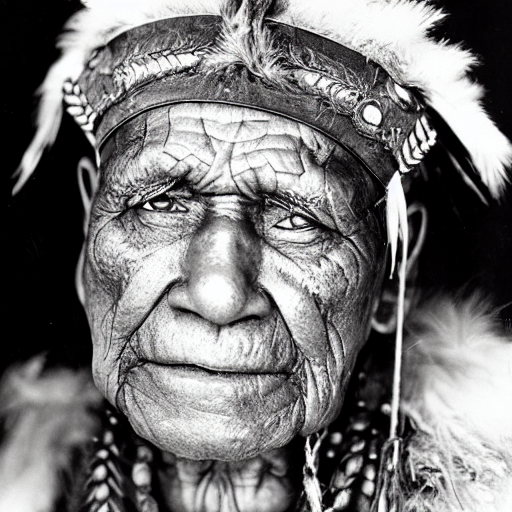

In [3]:
##initialize
from diffusers import DiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipeline = DiffusionPipeline.from_pretrained(model_id, use_auth_token=True)

prompt = "portrait photo of a old warriror chief"
pipeline= pipeline.to("cuda")
generator = torch.Generator("cuda").manual_seed(0)

image = pipeline(prompt, generator=generator).images[0]
image

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

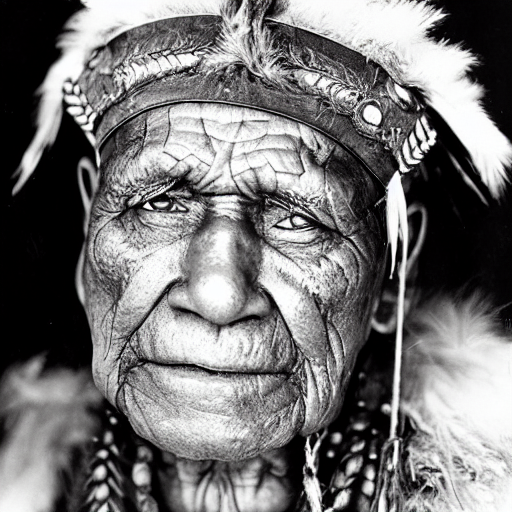

In [4]:
#float16

pipeline = DiffusionPipeline.from_pretrained(model_id, use_auth_token=True, torch_dtype = torch.float16)
pipeline = pipeline.to("cuda")
generator = torch.Generator("cuda").manual_seed(0)
image = pipeline(prompt, generator=generator).images[0]
image

In [5]:
#check compatible schedulers
pipeline.scheduler.compatibles

[diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_discrete.KDPM2DiscreteScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSDEScheduler,
 diffusers.schedulers.scheduling_lms_discrete.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultiste

  0%|          | 0/50 [00:00<?, ?it/s]

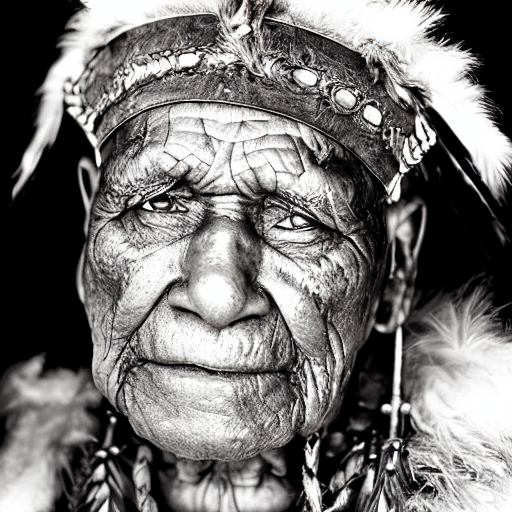

In [6]:
# Scheduler change
from diffusers import DPMSolverMultistepScheduler

pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)

generator = torch.Generator("cuda").manual_seed(0)
image = pipeline(prompt, generator=generator).images[0]
image

In [7]:
pipeline.scheduler.config

FrozenDict([('num_train_timesteps', 1000),
            ('beta_start', 0.00085),
            ('beta_end', 0.012),
            ('beta_schedule', 'scaled_linear'),
            ('trained_betas', None),
            ('solver_order', 2),
            ('prediction_type', 'epsilon'),
            ('thresholding', False),
            ('dynamic_thresholding_ratio', 0.995),
            ('sample_max_value', 1.0),
            ('algorithm_type', 'dpmsolver++'),
            ('solver_type', 'midpoint'),
            ('lower_order_final', True),
            ('use_karras_sigmas', False),
            ('lambda_min_clipped', -inf),
            ('variance_type', None),
            ('timestep_spacing', 'linspace'),
            ('steps_offset', 1),
            ('_use_default_values',
             ['algorithm_type',
              'sample_max_value',
              'dynamic_thresholding_ratio',
              'thresholding',
              'lower_order_final',
              'lambda_min_clipped',
              'timeste

# CMIA data generation

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from typing import List, Tuple


# example of root folder : /home/datasets/ImageNet1K/ILSVRC/Data/CLS-LOC
# example of image path : /home/datasets/ImageNet1K/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_8240.JPEG 
# example of caption path : /home/datasets/ImageNet1K/ILSVRC/Data/CLS-LOC/train_csv/n01440764/n01440764_8240.xml

# ImageCaptionPair Dataset
class ICP_Dataset(Dataset):
    def __init__(self, root_folder: Path, save_image_folder_name: Path):
        self.csv_list = list(root_folder.joinpath('train_csv').glob("*.csv"))
        self.save_image_path = root_folder.joinpath(save_image_folder_name)
        self.save_image_path.mkdir(parents=True, exist_ok=True)

        self.data = pd.concat([pd.read_csv(csv_file, sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python') for csv_file in self.csv_list])
        self.image_path = self.data["org_img_path"].tolist()
        self.caption = self.data["caption"].tolist()

        if len(self.image_path) != len(self.caption):
            raise ValueError("image_path and caption must have the same length")

        # self.image_class = list(map(lambda x: x.split("/")[-2], self.image_path))
        # self.image_name = list(map(lambda x: x.split("/")[-1].split(".")[0], self.image_path))

    def __getitem__(self, idx):
        prompt = self.caption[idx]
        generator_seed = idx
        num_inference_steps = 20

        image_path = Path(self.image_path[idx])
        image_cls = image_path.parts[-2]
        image_name = image_path.stem

        return {"prompt": prompt, "generator_seed": generator_seed, "num_inference_steps": num_inference_steps}, self.save_image_path.joinpath(image_cls).joinpath(image_name + ".png")

    def __len__(self):
        return len(self.data)

In [4]:
# example of root folder : /home/datasets/ImageNet1K/ILSVRC/Data/CLS-LOC
# example of image path : /home/datasets/ImageNet1K/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_8240.JPEG 
# example of caption path : /home/datasets/ImageNet1K/ILSVRC/Data/CLS-LOC/train_csv/n01440764/n01440764_8240.xml

class DualCaptionDataset(ICP_Dataset):
    def __init__(self, root_folder: Path, ensemble_class: List[str], save_image_folder_name: Path = Path("DualCaptionDataset")):
        super().__init__(root_folder, save_image_folder_name)

        # ensemble class define
        if len(ensemble_class) != 2:
            raise ValueError("ensemble_class must be a list of two class")
        else:
            self.ensemble_class = ensemble_class

        # Split the dataframe by classes
        self.data1 = pd.concat([pd.read_csv(csv_file, sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python') for csv_file in self.csv_list if csv_file.stem == self.ensemble_class[0]])
        self.data2 = pd.concat([pd.read_csv(csv_file, sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python') for csv_file in self.csv_list if csv_file.stem == self.ensemble_class[1]])

        self.image_path1 = self.data1["org_img_path"].tolist()
        self.image_path2 = self.data2["org_img_path"].tolist()

        self.caption1 = self.data1["caption"].tolist()
        self.caption2 = self.data2["caption"].tolist()

        self.length = min(len(self.data1), len(self.data2))  # Use the minimum length of the two dataframes

    def __getitem__(self, idx):
        generator_seed = idx
        num_inference_steps = 20

        # Select one caption from each class
        prompt1 = self.caption1[idx % len(self.caption1)]  # Use modulo to prevent index out of range
        prompt2 = self.caption2[idx % len(self.caption2)]  # Use modulo to prevent index out of range

        image_path1 = Path(self.image_path1[idx % len(self.image_path1)])
        image_cls1 = image_path1.parts[-2]
        image_name1 = image_path1.stem.split("_")[-1]

        image_path2 = Path(self.image_path2[idx % len(self.image_path2)])
        image_cls2 = image_path2.parts[-2]
        image_name2 = image_path2.stem.split("_")[-1]

        prompt = f"mixture of {prompt1} and {prompt2}"
        # image_path, image_cls, image_name = [image_path1, image_path2], [image_cls1, image_cls2], [image_name1, image_name2]

        save_path = self.save_image_path.joinpath(f"{image_cls1}_{image_cls2}/{image_name1}_{image_name2}.png")

        return {"prompt": prompt, "generator_seed": generator_seed, "num_inference_steps": num_inference_steps}, save_path

    def __len__(self):
        return self.length

In [5]:
root_folder = Path("/mnt/nas65/Dataset/ImageNet1K/ILSVRC/Data/CLS-LOC")

In [6]:
# dataset = ICP_Dataset(root_folder, None)
dataset = DualCaptionDataset(root_folder, ensemble_class= ["n02134084", "n04552348"])

In [7]:
def collate_fn(batch):
    # 데이터 및 메타데이터 리스트 분리
    data_list, meta_list = zip(*batch)

    # 데이터 배치 생성
    data_batch = {
        'prompt': [item['prompt'] for item in data_list],
        'generator_seed': torch.tensor([item['generator_seed'] for item in data_list]),
        'num_inference_steps': torch.tensor([item['num_inference_steps'] for item in data_list]),
    }

    # 메타데이터는 리스트로 유지
    meta_batch = list(meta_list)

    return data_batch, meta_batch

In [8]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=collate_fn)

  0%|          | 0/20 [00:00<?, ?it/s]

/mnt/nas65/Dataset/ImageNet1K/ILSVRC/Data/CLS-LOC/DualCaptionDataset/n02134084_n04552348/1131_2177.png


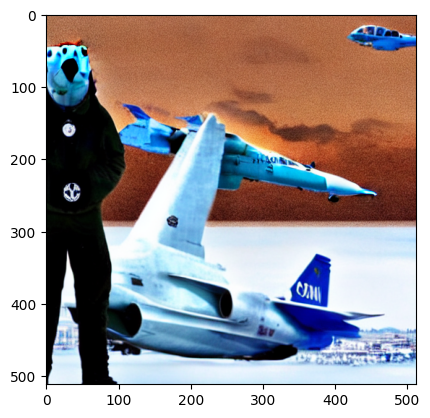

In [9]:
for batch_idx, (data_batch, path_batch) in enumerate(dataloader):
    generator = [torch.Generator(device="cuda").manual_seed(seed.item()) for seed in data_batch["generator_seed"]]
    data_batch["generator"] = generator
    data_batch.pop("generator_seed")
    data_batch["num_inference_steps"] = data_batch["num_inference_steps"][0].item()
    images = pipe(**data_batch).images
    for img, path in zip(images, path_batch):
        print(path)
        plt.imshow(img)
        break
    break

In [15]:
for dic, info in dataloader:
    print(len(dic['prompt']))
    print(len(info))
    break

4
4


In [1]:
import pandas as pd

polar_csv = pd.read_csv("/mnt/nas65/Dataset/ImageNet1K/ILSVRC/Data/CLS-LOC/train_csv/n02134084.csv", sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python')
maltese_csv = pd.read_csv("/mnt/nas65/Dataset/ImageNet1K/ILSVRC/Data/CLS-LOC/train_csv/n02085936.csv", sep=r",(?:(?!\s)+(?!')+(?!$))", engine='python')

In [2]:
print(polar_csv['org_img_path'][0])
print(polar_csv['caption'][0])
print(maltese_csv['org_img_path'][1])
print(maltese_csv['caption'][1])


/home/datasets/ImageNet1K/ILSVRC/Data/CLS-LOC/train/n02134084/n02134084_1131.JPEG
a polar bear is standing on a rock
/home/datasets/ImageNet1K/ILSVRC/Data/CLS-LOC/train/n02085936/n02085936_1712.JPEG
a small white dog laying on top of a wooden floor


In [3]:
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained(
	"CompVis/stable-diffusion-v1-1", 
	use_auth_token=True
).to("cuda")

vae/diffusion_pytorch_model.safetensors not found
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

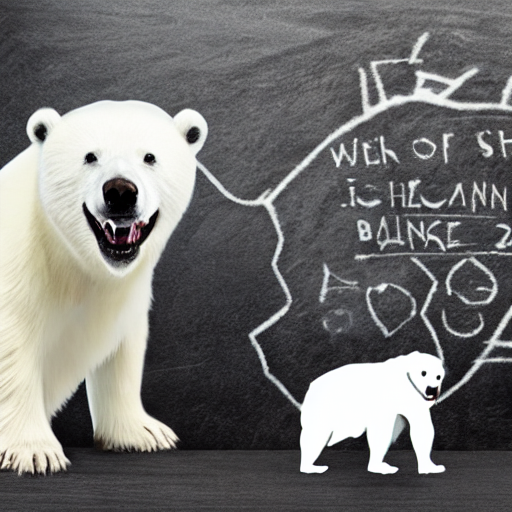

In [5]:
pipe("mixture of a polar bear is standing on a rock and a small white dog sitting in front of a blackboard").images[0] # type: ignore